In [20]:
from core.networks.SRGAN import Generator, Discriminator

from math import log10
import json

import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_msssim import ssim
from torchvision.transforms import functional as TF
import matplotlib.pyplot as plt
from safetensors.torch import load_model, save_model
from ignite.engine import Engine, Events
from ignite.metrics import SSIM, PSNR
from ignite.contrib.handlers import TensorboardLogger, global_step_from_engine

from data.get_data import get_bsd100, get_bsds500, get_div2k
import core.utils as U
from core.device import get_device
from core.loss import GeneratorLoss
from core.scheduler import CosineAnnealingWarmupRestarts

In [2]:
model_path = "./models"
result_path = "./results/SRGAN"

batch_size = 10
epochs = 200
generator_lr = 2e-4
discriminator_lr = 2e-4
upscale_factor = 4

log_interval_epoch = 1

generator_name = "SRGAN_generator"
discriminator_name = "SRGAN_discriminator"
device = get_device()

In [21]:
# train_loader, val_loader, test_loader = get_bsds500(4, batch_size)
train_loader, val_loader = get_div2k(4, batch_size)
test_loader = get_bsd100(4, 10)

Found cached dataset div2k (C:/Users/thinl/.cache/huggingface/datasets/eugenesiow___div2k/bicubic_x2/2.0.0/d7599f94c7e662a3eed3547efc7efa52b2ed71082b40fc2e42a693870e35b677)
Found cached dataset div2k (C:/Users/thinl/.cache/huggingface/datasets/eugenesiow___div2k/bicubic_x2/2.0.0/d7599f94c7e662a3eed3547efc7efa52b2ed71082b40fc2e42a693870e35b677)


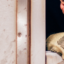

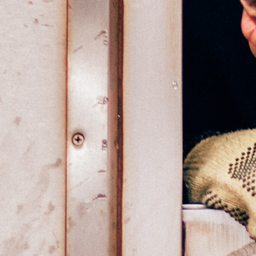

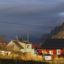

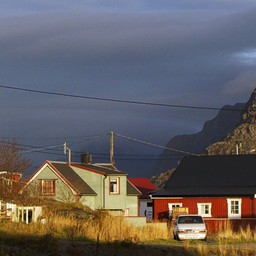

In [22]:
dateiter = iter(train_loader)
z, targets = next(dateiter)

for i in range(min(2, len(z))):
    input_image = TF.to_pil_image(z[i])
    target_image = TF.to_pil_image(targets[i])
    display(input_image)
    display(target_image)
    

In [5]:
generator = Generator(5)
discriminator = Discriminator()

use_pretrained_model = False

try:
    load_model(generator, f"{model_path}/{generator_name}.safetensors")
    load_model(discriminator, f"{model_path}/{discriminator_name}.safetensors")
    use_pretrained_model = True
    print("Using pretrained models")
except:
    print("No pretrained models found")

generator.to(device)
discriminator.to(device)

print("Model loaded")

No pretrained models found
Model loaded


In [6]:
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=discriminator_lr)
generator_optimizer = optim.Adam(generator.parameters(), lr=generator_lr)

discriminator_scheduler = CosineAnnealingWarmupRestarts(discriminator_optimizer, int(epochs/2), max_lr=discriminator_lr, min_lr = discriminator_lr / 100, warmup_steps = 2)
generator_scheduler = CosineAnnealingWarmupRestarts(generator_optimizer, int(epochs/2), max_lr=discriminator_lr, min_lr = discriminator_lr / 100, warmup_steps = 2)

discriminator_criterion = nn.BCELoss().to(device)
generator_criterion = GeneratorLoss().to(device)

loss_history = {
    "g_loss": [],
    "d_loss": [],
    "g_score": [],
    "d_score": [],
    "psnr": [],
    "ssim": []
}

metrics = {
    "ssim": SSIM(1.0, device=device),
    "psnr": PSNR(1.0, device=device),
}

In [7]:
import numpy as np
from PIL import Image
def training_step(engine, data):
    discriminator.train()
    generator.train()
    
    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    
    discriminator.zero_grad()
    
    z, targets = data[0].to(device), data[1].to(device)
    current_batch_size = z.size(0)
    
    G_z1 = generator(z)
    
    D_x = discriminator(targets).view(-1)
    D_x_loss = discriminator_criterion(D_x, torch.ones_like(D_x))
    D_x_loss.backward()
    
    D_G_z1 = discriminator(G_z1).view(-1)
    D_G_z_loss = discriminator_criterion(D_G_z1, torch.zeros_like(D_G_z1))
    D_G_z_loss.backward(retain_graph=True)
    
    d_loss = D_x_loss + D_G_z_loss
    discriminator_optimizer.step()
    
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    
    generator.zero_grad()
    
    g_loss = generator_criterion(D_G_z1, G_z1, targets)
    g_loss.backward()
    
    G_z2 = generator(z)
    D_G_z2 = discriminator(G_z2)

    generator_optimizer.step()
    
    return {
        "g_loss": g_loss.cpu().item(),
        "d_loss": d_loss.cpu().item(),
        "D_x": D_x.mean().cpu().item(),
        "D_G_z1": D_G_z1.mean().cpu().item(),
        "D_G_z2": D_G_z2.mean().cpu().item()
    }
    
def validation_step(engine, data):
    generator.eval()
    
    with torch.no_grad():
        z, targets = data[0].to(device), data[1].to(device)
                
        G_z = generator(z)

        return G_z, targets
    
trainer = Engine(training_step)
train_evaluator = Engine(validation_step)
val_evaluator = Engine(validation_step)

for name, metric in metrics.items():
    metric.attach(train_evaluator, name)
    metric.attach(val_evaluator, name)

@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    out = engine.state.output
    loss_history["g_loss"].append(out["g_loss"])
    loss_history["d_loss"].append(out["d_loss"])
    loss_history["g_score"].append(out["D_G_z2"])
    loss_history["d_score"].append(out["D_x"])

@trainer.on(Events.EPOCH_COMPLETED(every=log_interval_epoch))
def log_result(engine):
    print(f"Epoch {engine.state.epoch}/{epochs} completed")
    print(f"g_loss: {loss_history['g_loss'][-1]:.4f}, d_loss: {loss_history['d_loss'][-1]:.4f}, g_score: {loss_history['g_score'][-1]:.4f}, d_score: {loss_history['d_score'][-1]:.4f}")
    
@trainer.on(Events.EPOCH_COMPLETED(every=log_interval_epoch))
def log_training_results(engine):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    print(f"Train evalutate - ssim: {metrics['ssim']}, psnr: {metrics['psnr']}")

@trainer.on(Events.EPOCH_COMPLETED(every=log_interval_epoch))
def log_validation_results(engine):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    print(f"Validation evalutate - ssim: {metrics['ssim']}, psnr: {metrics['psnr']}")
    
@trainer.on(Events.EPOCH_COMPLETED(every=log_interval_epoch))
def save_images(engine):
    generator.eval()
    with torch.no_grad():
        dateiter = iter(train_loader)
        z, targets = next(dateiter)
        input_image = TF.to_pil_image(z[0])
        target_image = TF.to_pil_image(targets[0])

        generated = generator(z[0].unsqueeze(0).to(device))
        generated_image = TF.to_pil_image(generated.cpu().squeeze(0))
        
        input_image.save(f"{result_path}/SRGAM/img/input_{engine.state.epoch}.png")
        target_image.save(f"{result_path}/SRGAM/img/target_{engine.state.epoch}.png")
        generated_image.save(f"{result_path}/SRGAM/img/generated_{engine.state.epoch}.png")
    
@trainer.on(Events.COMPLETED)
def save():
    save_model(generator, f"{model_path}/{generator_name}.safetensors")
    save_model(discriminator, f"{model_path}/{discriminator_name}.safetensors")

In [8]:
tb_logger = TensorboardLogger(log_dir=result_path)

for tag, evaluator in [("training", train_evaluator), ("validation", val_evaluator)]:
    tb_logger.attach_output_handler(
        evaluator, event_name=Events.EPOCH_COMPLETED, tag=tag, metric_names="all", global_step_transform=global_step_from_engine(trainer)
    )

In [9]:
trainer.run(train_loader, max_epochs=epochs)

tb_logger.close()

Epoch 1/200 completed
g_loss: 2.0965, d_loss: 1.4156, g_score: 0.2438, d_score: 0.6345
Train evalutate - ssim: 0.0002967948664034656, psnr: -2.9715133185586757
Validation evalutate - ssim: 0.00027169691796275527, psnr: -3.0641099812259927
Epoch 2/200 completed
g_loss: 1.5338, d_loss: 0.7832, g_score: 0.3280, d_score: 0.8857
Train evalutate - ssim: 0.0005589614280714985, psnr: -1.7554692189496015
Validation evalutate - ssim: 0.0005332643652349285, psnr: -1.8077551628773305
Epoch 3/200 completed
g_loss: 1.1963, d_loss: 0.5724, g_score: 0.2465, d_score: 0.7701
Train evalutate - ssim: 0.0009405444837131512, psnr: -0.43479467391007526
Validation evalutate - ssim: 0.0009259451308299797, psnr: -0.4645162539371106
Epoch 4/200 completed
g_loss: 0.9820, d_loss: 0.8591, g_score: 0.3174, d_score: 0.8085
Train evalutate - ssim: 0.0013980136178542285, psnr: 0.6550137585473657
Validation evalutate - ssim: 0.0014276951662775131, psnr: 0.6710477719880124
Epoch 5/200 completed
g_loss: 0.8049, d_loss: 0.

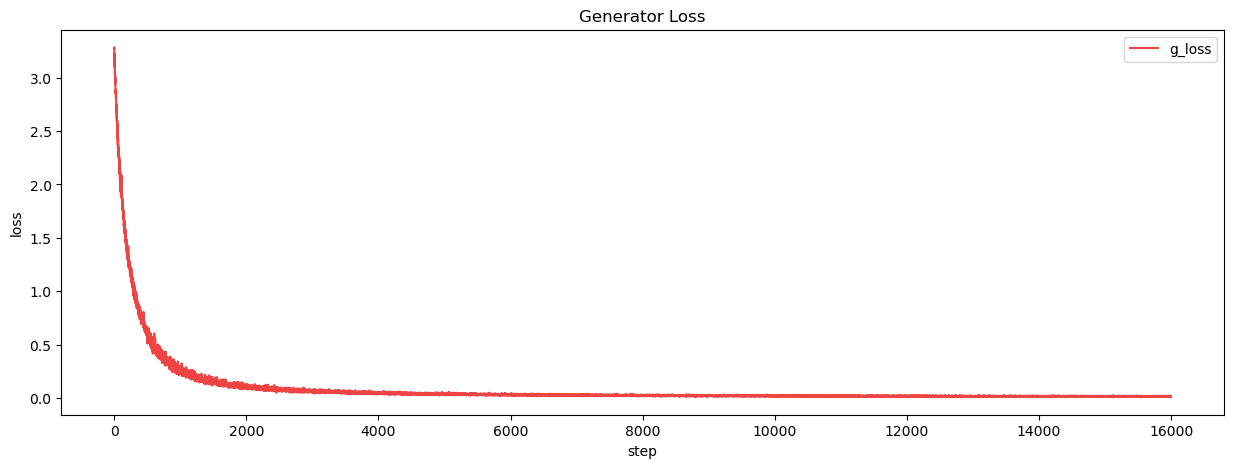

Min generator loss: 0.0077344817109405994


In [14]:
X = np.arange(16000)

fig = plt.gcf()
plt.plot(X, loss_history["g_loss"], color=U.get_color(0), label="g_loss")
plt.xlabel("step")
plt.ylabel("loss")
plt.legend()
plt.title("Generator Loss")
fig.set_size_inches(15, 5)
plt.show()
print(f"Min generator loss: {min(loss_history['g_loss'])}")

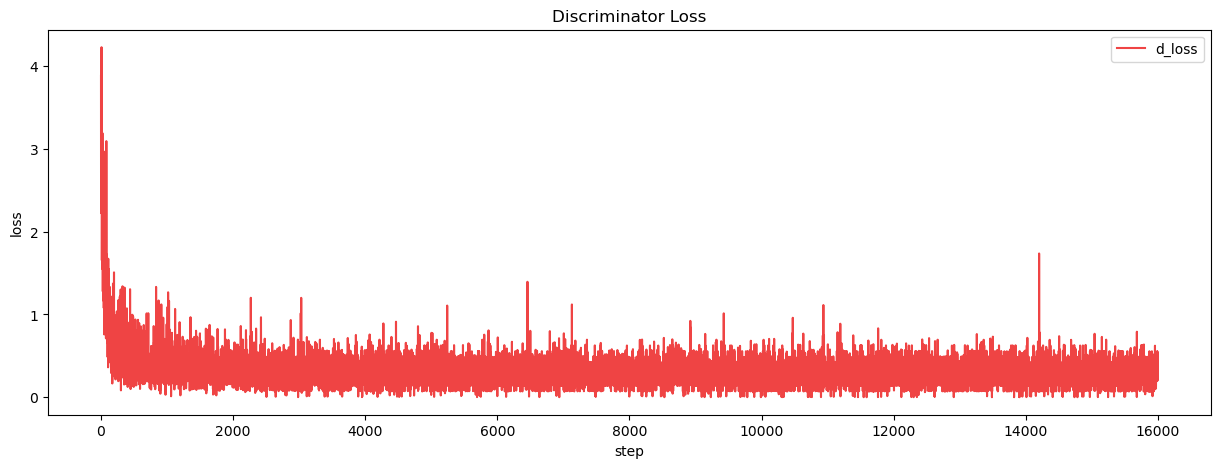

Min discriminator loss: 0.00018655307940207422


In [15]:
fig = plt.gcf()
plt.plot(X, loss_history["d_loss"], color=U.get_color(0), label="d_loss")
plt.xlabel("step")
plt.ylabel("loss")
plt.legend()
plt.title("Discriminator Loss")
fig.set_size_inches(15, 5)
plt.show()
print(f"Min discriminator loss: {min(loss_history['d_loss'])}")

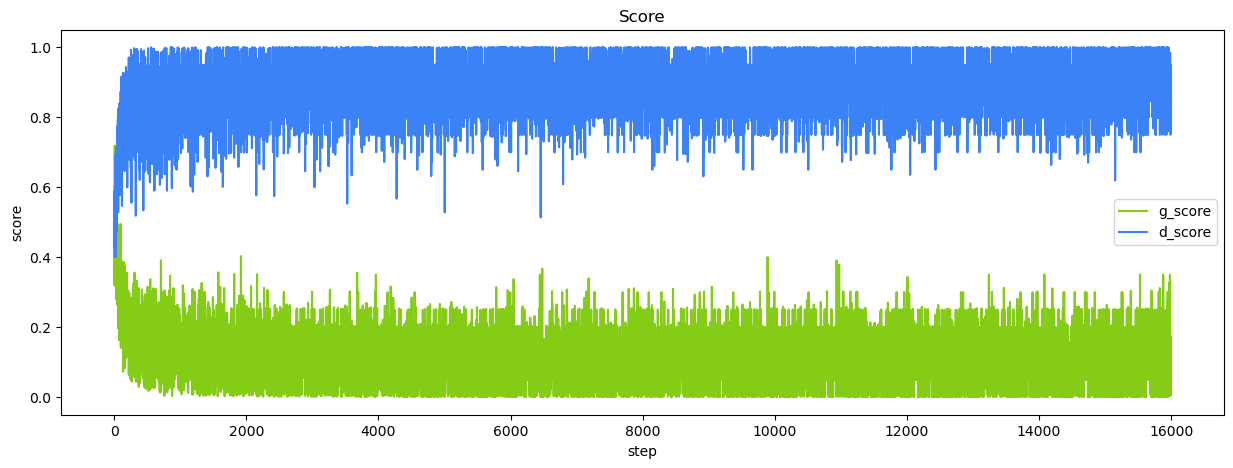

In [16]:
fig = plt.gcf()
plt.plot(X, loss_history["g_score"], color=U.get_color(4), label="g_score")
plt.plot(X, loss_history["d_score"], color=U.get_color(10), label="d_score")
plt.xlabel("step")
plt.ylabel("score")
plt.legend()
plt.title("Score")
fig.set_size_inches(15, 5)
plt.show()

In [26]:
%load_ext tensorboard --logdir=./results/SRGAN

====================Image 1====================
Low Resolution


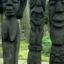

High Resolution


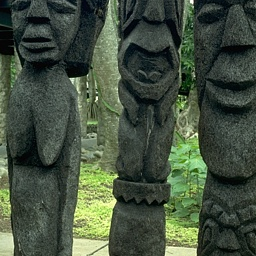

Generated Image


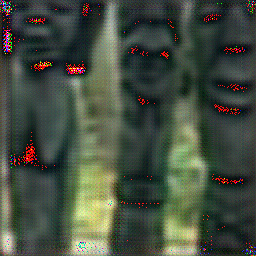

====================Image 2====================
Low Resolution


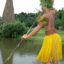

High Resolution


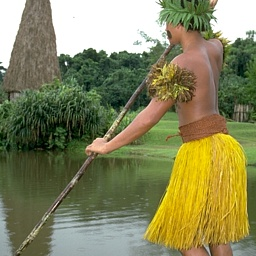

Generated Image


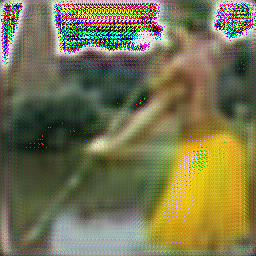

In [24]:
dateiter = iter(test_loader)
z, targets = next(dateiter)

for i in range(min(2, len(z))):
    print(f"====================Image {i+1}====================")
    input_image = TF.to_pil_image(z[i])
    target_image = TF.to_pil_image(targets[i])
    print("Low Resolution")
    display(input_image)
    print("High Resolution")
    display(target_image)

    generated = generator(z[i].unsqueeze(0).to(device))
    generated_image = TF.to_pil_image(generated.cpu().squeeze(0))
    print("Generated Image")
    display(generated_image)

In [14]:
# Old code
if not use_pretrained_model:
    for epoch in range(1, epochs + 1):
        print(f"train epoch {epoch}")
        generator.train()
        discriminator.train()
        
        running_results = {"g_loss": 0, "d_loss": 0, "g_score": 0, "d_score": 0, "batch_sizes": 0}

        for i, data in enumerate(train_loader):
            z, targets = data[0].to(device), data[1].to(device)
            
            running_results["batch_sizes"] += z.size(0)

            # 1. update discriminator - maximize log(D(x)) + log(1 - D(G(z)))
            discriminator.zero_grad()
            
            outputs = generator(z)

            d_real = discriminator(targets).view(-1)
            d_real_loss = discriminator_criterion(d_real, torch.ones_like(d_real, device=device))
            d_real_loss.backward()
            D_x = torch.mean(d_real).cpu().item()
            
            d_fake = discriminator(outputs.detach()).view(-1)
            d_fake_loss = discriminator_criterion(d_fake, torch.zeros_like(d_fake, device=device))
            d_fake_loss.backward(retain_graph=True)

            d_loss = d_real_loss + d_fake_loss
            
            # d_real = discriminator(targets).mean()
            # d_fake = discriminator(outputs).mean()

            # d_loss = 1 - d_real + d_fake
            # d_loss.backward(retain_graph=True)
            
            # d_real = discriminator(targets)
            # d_fake = discriminator(outputs)
            
            # d_real_loss = discriminator_criterion(d_real, torch.ones_like(d_real))
            # d_fake_loss = discriminator_criterion(d_fake, torch.zeros_like(d_fake))
            
            # d_real_loss.backward()
            # d_fake_loss.backward(retain_graph=True)
            
            # d_loss = d_real_loss + d_fake_loss
            
            discriminator_optimizer.step()

            # 2. update generator - maximize log(D(G(z)))
            generator.zero_grad()
            
            g_loss = generator_criterion(d_fake, outputs, targets)
            g_loss.backward()
            
            outputs = generator(z)
            d_fake = discriminator(outputs)

            generator_optimizer.step()
            
            running_results["g_loss"] = g_loss.cpu().item()
            running_results["d_loss"] = d_loss.cpu().item()
            running_results["g_score"] += d_fake.mean().cpu().item() * batch_size
            running_results["d_score"] += d_real.mean().cpu().item() * batch_size
        
        generator_scheduler.step()
        discriminator_scheduler.step()
        
        generator.eval()

        with torch.no_grad():
            print(f"validate epoch {epoch}")
            val_results = {"mse": 0, "ssims": 0, "psnr": 0, "ssim": 0, "batch_sizes": 0}
            
            for i, data in enumerate(val_loader):
                z, targets = data[0].to(device), data[1].to(device)
                
                val_results["batch_sizes"] += z.size(0)
                
                outputs = generator(z)
                
                mse = torch.mean((outputs - targets) ** 2)
                val_results["mse"] = mse.cpu().item() * z.size(0)

                ssim_val = ssim(outputs, targets, data_range=1.0).cpu().item()
                val_results["ssims"] += ssim_val * z.size(0)
                # val_results["psnr"] = 10 * log10(((targets.max().cpu().item() ** 2) / val_results["mse"]) / val_results["batch_sizes"])
                val_results["psnr"] = (20 * log10(targets.max().cpu().item()) - 10 * log10(val_results["mse"])) / z.size(0)
                val_results["ssim"] = val_results["ssims"] / val_results["batch_sizes"]
        
        loss_history["d_loss"].append(running_results["d_loss"])
        loss_history["g_loss"].append(running_results["g_loss"])
        loss_history["d_score"].append(running_results["d_score"] / running_results["batch_sizes"])
        loss_history["g_score"].append(running_results["g_score"] / running_results["batch_sizes"])
        loss_history["psnr"].append(val_results["psnr"])
        loss_history["ssim"].append(val_results["ssim"])

        # if epoch % 10 == 0:
        if True:
            print(f"Epoch {epoch} - D loss: {running_results['d_loss']} - G loss: {running_results['g_loss']}")
            print(f"Epoch {epoch} - D score: {running_results['d_score'] / running_results['batch_sizes']} - G score: {running_results['g_score'] / running_results['batch_sizes']}")
            print(f"Epoch {epoch} - PSNR: {val_results['psnr']} - SSIM: {val_results['ssim']}")
            print("-------------")

            
    with open(f"{result_path}/SRGAN.txt", "w", encoding="utf-8") as f:
        f.write(json.dumps(loss_history, indent=2))

    save_model(generator, f"{model_path}/{generator_name}.safetensors")
    save_model(discriminator, f"{model_path}/{discriminator_name}.safetensors")
else:
    with open(f"{result_path}/SRGAN.txt", "r", encoding="utf-8") as f:
        loss_history = json.load(f)

train epoch 1
validate epoch 1
Epoch 1 - D loss: 0.6516366004943848 - G loss: 0.02871420793235302
Epoch 1 - D score: 0.8085502974689007 - G score: 0.15281531420386077
Epoch 1 - PSNR: 0.6421121587850107 - SSIM: 0.1594057023525238
-------------
train epoch 2


KeyboardInterrupt: 